# Proyecto Final: Clasificación de Sentimientos

In [656]:
# Librerías principales
import pandas as pd
import numpy as np


import torch
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import unicodedata

# Preprocesamiento de texto
import re
from collections import Counter
#Identificar palabras clave por sentimientos
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
# Configuracion
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Dividir el data set
from sklearn.model_selection import train_test_split



#Importamos las librerias para los algoritmos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm

from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel

# COLORES DE MATPLOT y tamaño de las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [657]:
# Descargar las stopwords de nltk (solo la primera vez)
nltk.download('stopwords')

# Obtener las stopwords en español de nltk
stopwords_espanol = set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juansota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1> Análisis Exploratorio de Datos (EDA) </h1>

In [658]:
# Cargar el dataset
dataset_path = "Textos_Dataset_Completo.csv"  # Cambia el path si es necesario
dataset = pd.read_csv(dataset_path, encoding="latin1")

In [659]:
# Mostrar información básica
print("Información del Dataset:")
print(dataset.info())

Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Marca_temporal             288 non-null    object
 1   ID_Unico                   287 non-null    object
 2   Edad                       288 non-null    int64 
 3   Genero                     288 non-null    object
 4   Nivel socioeconomico       288 non-null    object
 5   Grado de estudios          288 non-null    object
 6   Actualmente_te_encuentras  288 non-null    object
 7   En_que_area_trabajas       288 non-null    object
 8   Estado_origen              288 non-null    object
 9   Municipio_origen           288 non-null    object
 10  Pregunta1                  288 non-null    object
 11  Pregunta2                  288 non-null    object
 12  Pregunta3                  288 non-null    object
 13  Pregunta4                  288 non-null 

In [660]:
print("\nVista preliminar del Dataset:")
print(dataset.head())


Vista preliminar del Dataset:
       Marca_temporal  ID_Unico  Edad     Genero Nivel socioeconomico  \
0  4/23/2024 19:48:07  PFNKXS54    28  Masculino                Medio   
1  4/23/2024 19:48:07  MKZUPRJI    21  Masculino                 Bajo   
2  4/23/2024 19:48:07  UJCL56SG    22  Masculino                Medio   
3  4/23/2024 19:48:07  B2KUCT4P    20   Femenino                Medio   
4  4/23/2024 19:48:07  GXLRPJ5F    22   Femenino                Medio   

  Grado de estudios Actualmente_te_encuentras  \
0          Maestra                     Ambos   
1      Licenciatura                     Ambos   
2      Licenciatura                     Ambos   
3      Licenciatura                Estudiando   
4      Licenciatura                Estudiando   

                                En_que_area_trabajas Estado_origen  \
0  Sector de la educacin - Maestros, educadores,...      Veracruz   
1  Comercio y ventas - Vendedores, gerentes de ti...      Veracruz   
2  Sector administrativo 

In [661]:
# Verificar valores nulos
print("\nValores nulos por columna:")
print(dataset.isnull().sum())


Valores nulos por columna:
Marca_temporal               0
ID_Unico                     1
Edad                         0
Genero                       0
Nivel socioeconomico         0
Grado de estudios            0
Actualmente_te_encuentras    0
En_que_area_trabajas         0
Estado_origen                0
Municipio_origen             0
Pregunta1                    0
Pregunta2                    0
Pregunta3                    0
Pregunta4                    0
Pregunta5                    0
Pregunta6                    0
Pregunta7                    0
Pregunta8                    0
Pregunta9                    0
Pregunta10                   0
dtype: int64


In [662]:
#Eliminar valores nulos
dataset.dropna(inplace=True)

In [663]:
#Verificar valores nulos
print("\nValores nulos por columna:")
print(dataset.isnull().sum())


Valores nulos por columna:
Marca_temporal               0
ID_Unico                     0
Edad                         0
Genero                       0
Nivel socioeconomico         0
Grado de estudios            0
Actualmente_te_encuentras    0
En_que_area_trabajas         0
Estado_origen                0
Municipio_origen             0
Pregunta1                    0
Pregunta2                    0
Pregunta3                    0
Pregunta4                    0
Pregunta5                    0
Pregunta6                    0
Pregunta7                    0
Pregunta8                    0
Pregunta9                    0
Pregunta10                   0
dtype: int64


In [664]:
# Explorar la cantidad de respuestas disponibles para cada pregunta
preguntas = [col for col in dataset.columns if "Pregunta" in col]  # Identificar columnas relacionadas con preguntas

print("\nCantidad de respuestas por pregunta:")
respuestas_por_pregunta = dataset[preguntas].notnull().sum()
print(respuestas_por_pregunta)

# Verificar la representación de sentimientos si existe una columna para ello
if "Sentimiento" in dataset.columns:  # Cambia "Sentimiento" por el nombre real de la columna si existe
    print("\nFrecuencia de respuestas por categoría de sentimiento:")
    sentimiento_frecuencia = dataset["Sentimiento"].value_counts()
    print(sentimiento_frecuencia)
    
    # Verificar si hay categorías desbalanceadas
    total_sentimientos = sentimiento_frecuencia.sum()
    print("\nPorcentaje de representación por sentimiento:")
    representacion_sentimientos = (sentimiento_frecuencia / total_sentimientos) * 100
    print(representacion_sentimientos)
else:
    print("\nNo se encontró una columna de sentimientos en el DataFrame.")


Cantidad de respuestas por pregunta:
Pregunta1     287
Pregunta2     287
Pregunta3     287
Pregunta4     287
Pregunta5     287
Pregunta6     287
Pregunta7     287
Pregunta8     287
Pregunta9     287
Pregunta10    287
dtype: int64

No se encontró una columna de sentimientos en el DataFrame.



Cantidad de respuestas disponibles por sentimiento:
Alegría: 574
Tristeza: 287
Estrés: 574
Inquietud/Preocupación: 574
Miedo: 574
Enojo: 287


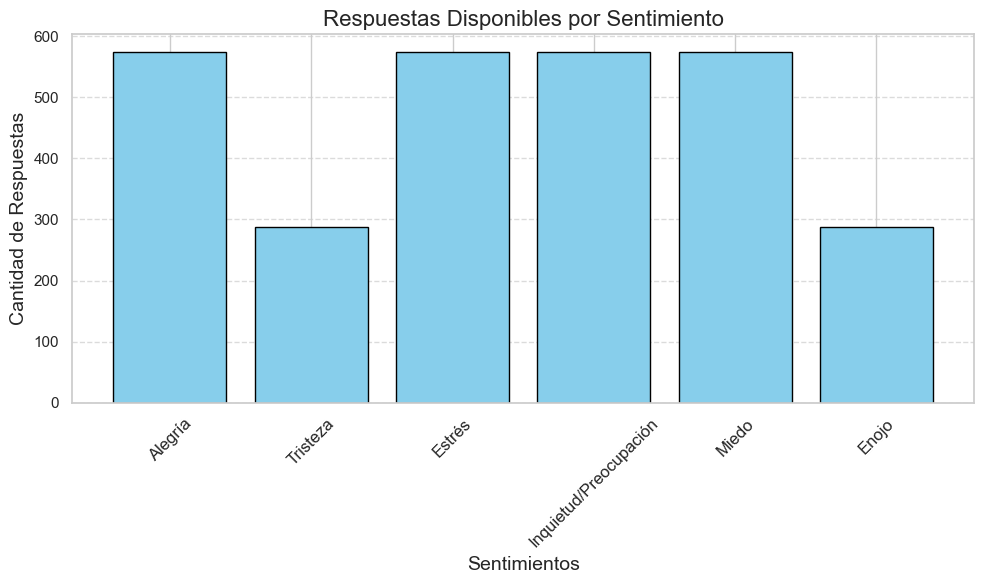

In [665]:
# Definir las preguntas asociadas a cada sentimiento
sentimientos_preguntas = {
    "Alegría": ["Pregunta1", "Pregunta6"],
    "Tristeza": ["Pregunta2"],
    "Estrés": ["Pregunta3", "Pregunta9"],
    "Inquietud/Preocupación": ["Pregunta4", "Pregunta5"],
    "Miedo": ["Pregunta7", "Pregunta10"],
    "Enojo": ["Pregunta8"]
}

# Calcular el número de respuestas para cada sentimiento
respuestas_por_sentimiento = {
    sentimiento: dataset[preguntas].notnull().sum().sum()
    for sentimiento, preguntas in sentimientos_preguntas.items()
}

# Mostrar el conteo de respuestas por sentimiento
print("\nCantidad de respuestas disponibles por sentimiento:")
for sentimiento, cantidad in respuestas_por_sentimiento.items():
    print(f"{sentimiento}: {cantidad}")

plt.figure(figsize=(10, 6))
plt.bar(respuestas_por_sentimiento.keys(), respuestas_por_sentimiento.values(), color='skyblue', edgecolor='black')
plt.title("Respuestas Disponibles por Sentimiento", fontsize=16)
plt.xlabel("Sentimientos", fontsize=14)
plt.ylabel("Cantidad de Respuestas", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

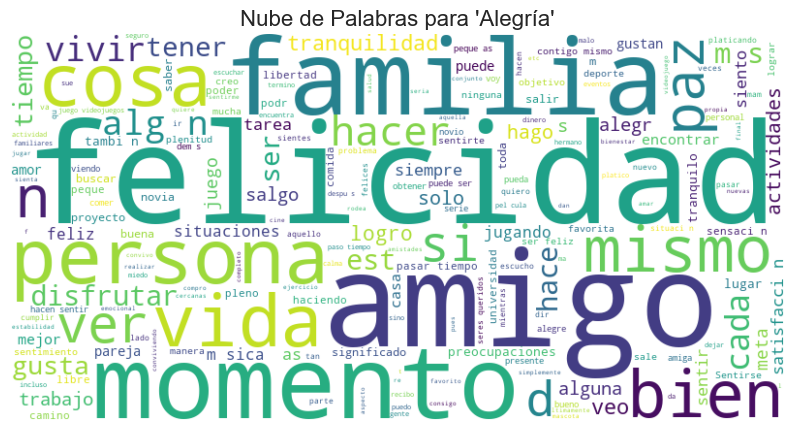

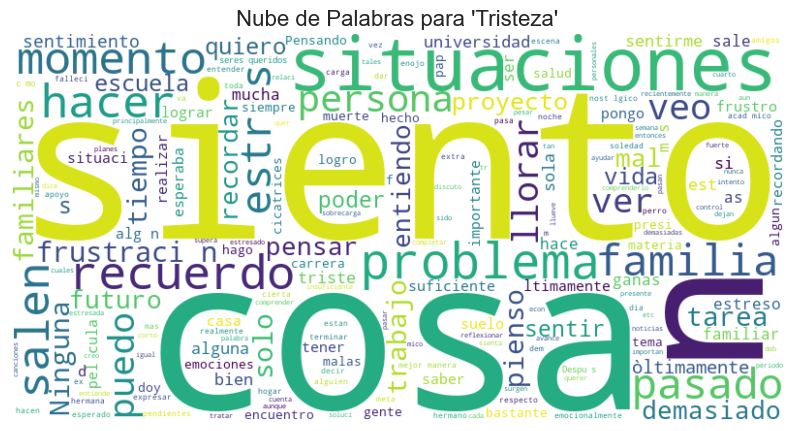

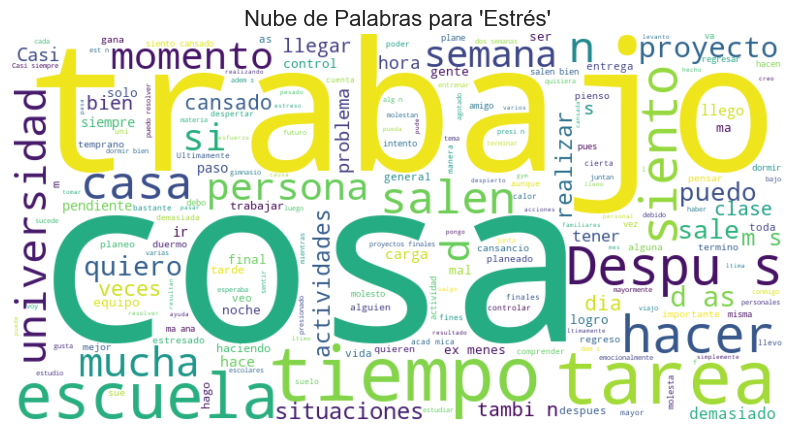

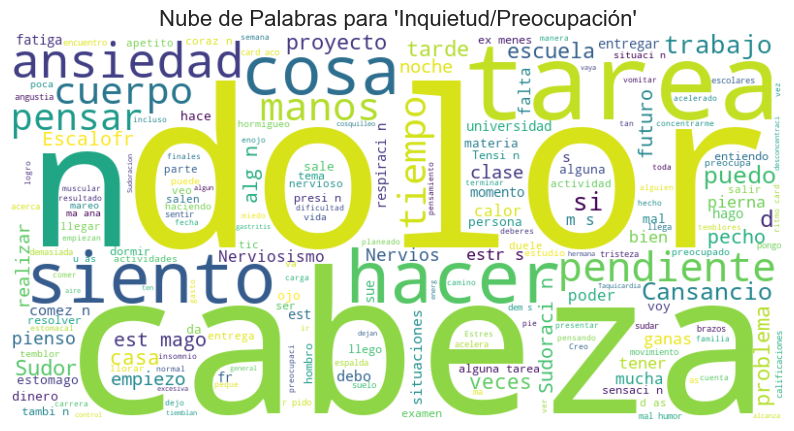

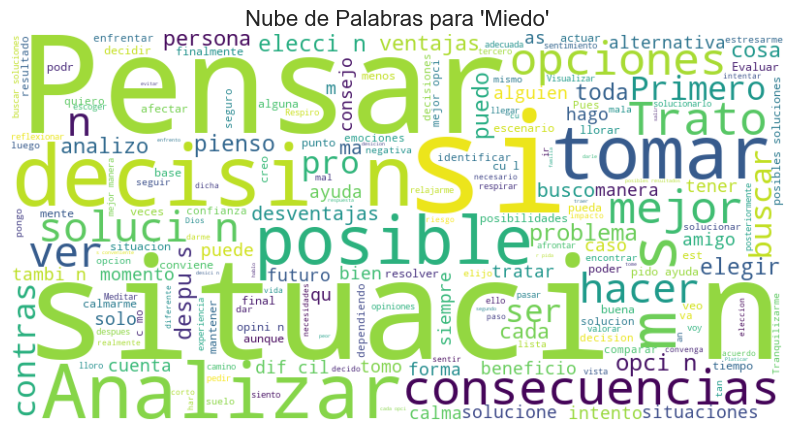

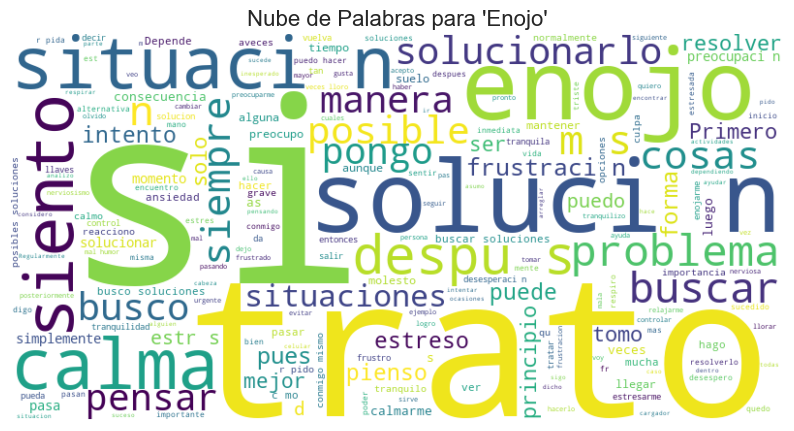

In [666]:
# Generar nubes de palabras con stopwords eliminadas
def generar_nube_palabras(sentimientos_preguntas, dataset):
    for sentimiento, preguntas in sentimientos_preguntas.items():
        # Combinar el texto de las preguntas asociadas al sentimiento
        texto = " ".join(dataset[preguntas].fillna("").apply(" ".join, axis=1))
        
        # Crear la nube de palabras con las stopwords de nltk
        nube = WordCloud(
            width=800, height=400, background_color='white', colormap='viridis',
            stopwords=stopwords_espanol
        ).generate(texto)
        
        # Mostrar la nube de palabras
        plt.figure(figsize=(10, 6))
        plt.imshow(nube, interpolation='bilinear')
        plt.title(f"Nube de Palabras para '{sentimiento}'", fontsize=16)
        plt.axis('off')
        plt.show()

# Ejecutar la generación de nubes de palabras
generar_nube_palabras(sentimientos_preguntas, dataset)

In [667]:
# Identificar las palabras más frecuentes para cada sentimiento
def palabras_frecuentes_por_sentimiento(sentimientos_preguntas, dataset, stopwords):
    resultados = {}
    
    for sentimiento, preguntas in sentimientos_preguntas.items():
        # Combinar el texto de las preguntas asociadas al sentimiento
        texto = " ".join(dataset[preguntas].fillna("").apply(" ".join, axis=1))
        
        # Dividir el texto en palabras y eliminar stopwords
        palabras = [word.lower() for word in texto.split() if word.lower() not in stopwords]
        
        # Contar la frecuencia de cada palabra
        contador = Counter(palabras)
        resultados[sentimiento] = contador.most_common(10)  # Obtener las 10 palabras más frecuentes
    
    return resultados

# Usar las stopwords en español de nltk
stopwords_espanol = set(stopwords.words('spanish'))

# Obtener las palabras más frecuentes para cada sentimiento
frecuencias = palabras_frecuentes_por_sentimiento(sentimientos_preguntas, dataset, stopwords_espanol)

# Mostrar las palabras más frecuentes por sentimiento
for sentimiento, palabras in frecuencias.items():
    print(f"\nPalabras más frecuentes para '{sentimiento}':")
    for palabra, frecuencia in palabras:
        print(f"{palabra}: {frecuencia}")


Palabras más frecuentes para 'Alegría':
felicidad: 112
amigos: 69
cosas: 48
familia: 45
personas: 41
tiempo: 40
vida: 38
momentos: 37
bien: 36
ser: 34

Palabras más frecuentes para 'Tristeza':
siento: 48
cosas: 45
situaciones: 31
salen: 20
recuerdo: 20
problemas: 17
hacer: 16
veo: 14
pasado: 14
estrs: 14

Palabras más frecuentes para 'Estrés':
cosas: 92
siento: 55
tiempo: 55
trabajo: 50
despus: 50
salen: 47
hacer: 46
escuela: 40
tareas: 30
casa: 30

Palabras más frecuentes para 'Inquietud/Preocupación':
dolor: 88
siento: 42
hacer: 42
cabeza,: 36
cabeza: 34
cosas: 34
tareas: 25
ansiedad: 25
si: 24
pensar: 23

Palabras más frecuentes para 'Miedo':
si: 120
pensar: 112
analizar: 89
situacin: 85
tomar: 81
ms: 78
mejor: 73
decisin: 69
trato: 65
posibles: 62

Palabras más frecuentes para 'Enojo':
si: 69
trato: 49
solucin: 34
buscar: 30
enojo: 30
despus: 28
siento: 28
busco: 25
calma: 23
situacin: 20


<h1> Preprocesamiento de Texto </h1>

In [668]:
print(dataset.columns)

Index(['Marca_temporal', 'ID_Unico', 'Edad', 'Genero', 'Nivel socioeconomico',
       'Grado de estudios', 'Actualmente_te_encuentras',
       'En_que_area_trabajas', 'Estado_origen', 'Municipio_origen',
       'Pregunta1', 'Pregunta2', 'Pregunta3', 'Pregunta4', 'Pregunta5',
       'Pregunta6', 'Pregunta7', 'Pregunta8', 'Pregunta9', 'Pregunta10'],
      dtype='object')


In [669]:
# Inicializar lematizador y stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Lista de stopwords en español
stop_words = set(stopwords.words('spanish'))


# Función para limpiar texto, incluyendo la eliminación de acentos
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    # Eliminar acentos usando unicodedata
    texto = unicodedata.normalize('NFD', texto).encode('ascii', 'ignore').decode('utf-8')
    texto = re.sub(r"[^\w\s]", "", texto)  # Eliminar caracteres especiales
    texto = re.sub(r"\d+", "", texto)  # Eliminar números
    return texto

In [670]:
# Función para procesar texto
def procesar_texto(texto, stop_words, lematizar=True):
    texto_limpio = limpiar_texto(texto)
    palabras = texto_limpio.split()  # Tokenización
    palabras = [palabra for palabra in palabras if palabra not in stop_words]  # Eliminar stopwords
    
    # Aplicar lematización o stemming
    if lematizar:
        palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras]
    else:
        palabras = [stemmer.stem(palabra) for palabra in palabras]
    return " ".join(palabras)  # Reunir palabras en un solo string

In [671]:
# Función para procesar todas las columnas
def procesar_todas_las_columnas(dataset, columnas_texto, stop_words):
    """
    Procesa texto en las columnas especificadas del dataset.
    """
    for col in columnas_texto:
        dataset[col] = dataset[col].fillna("").apply(
            lambda x: procesar_texto(x, stop_words) if isinstance(x, str) else x
        )
    return dataset

In [672]:
# Función para procesar todas las columnas
def procesar_todas_las_columnas(dataset, columnas_texto, stop_words):
    """
    Procesa texto en las columnas especificadas del dataset.
    """
    for col in columnas_texto:
        dataset[col] = dataset[col].fillna("").apply(
            lambda x: procesar_texto(x, stop_words) if isinstance(x, str) else x
        )
    return dataset

In [673]:
# Identificar columnas relacionadas con texto
columnas_texto = [col for col in dataset.columns if "Pregunta" in col]

# Aplicar el procesamiento
dataset = procesar_todas_las_columnas(dataset, columnas_texto, stop_words)

# Verificar los resultados
print("Texto procesado:")
print(dataset.head())

Texto procesado:
       Marca_temporal  ID_Unico  Edad     Genero Nivel socioeconomico  \
0  4/23/2024 19:48:07  PFNKXS54    28  Masculino                Medio   
1  4/23/2024 19:48:07  MKZUPRJI    21  Masculino                 Bajo   
2  4/23/2024 19:48:07  UJCL56SG    22  Masculino                Medio   
3  4/23/2024 19:48:07  B2KUCT4P    20   Femenino                Medio   
4  4/23/2024 19:48:07  GXLRPJ5F    22   Femenino                Medio   

  Grado de estudios Actualmente_te_encuentras  \
0          Maestra                     Ambos   
1      Licenciatura                     Ambos   
2      Licenciatura                     Ambos   
3      Licenciatura                Estudiando   
4      Licenciatura                Estudiando   

                                En_que_area_trabajas Estado_origen  \
0  Sector de la educacin - Maestros, educadores,...      Veracruz   
1  Comercio y ventas - Vendedores, gerentes de ti...      Veracruz   
2  Sector administrativo y de oficina -

In [674]:
# Función para tokenizar texto
def tokenizar_texto(texto):
    """
    Toma un texto y lo divide en palabras individuales (tokens).
    """
    tokens = word_tokenize(texto)  # Tokenización
    return tokens

# Aplicar la tokenización a todas las columnas relacionadas con texto
def tokenizar_columnas_texto(dataset, columnas_texto):
    """
    Aplica tokenización a todas las columnas especificadas del dataset.
    """
    for columna in columnas_texto:
        dataset[columna + "_tokens"] = dataset[columna].apply(tokenizar_texto)  # Crear columna con tokens
    return dataset

# Identificar las columnas de texto
columnas_texto = [col for col in dataset.columns if "Pregunta" in col]

# Aplicar tokenización
dataset = tokenizar_columnas_texto(dataset, columnas_texto)

# Verificar el resultado
for columna in columnas_texto:
    print(f"Tokens para la columna '{columna}':")
    print(dataset[columna + "_tokens"].head())

Tokens para la columna 'Pregunta1':
0    [dando, clases, puedo, salir, divertirme, amig...
1                       [sale, bien, escuela, trabajo]
2    [ver, recuerdos, pensar, escenarios, imaginarios]
3         [paso, tiempo, amigo, salir, comer, lugares]
4    [hago, recibo, halagos, hago, ejercicio, escuc...
Name: Pregunta1_tokens, dtype: object
Tokens para la columna 'Pregunta2':
0    [frustrado, poder, hacer, trabajo, siento, dan...
1                                       [salen, cosas]
2    [pensar, cosas, pasen, planear, cosas, sucedan...
3                               [cosas, salen, quiero]
4                      [enojo, hermanas, enojo, novio]
Name: Pregunta2_tokens, dtype: object
Tokens para la columna 'Pregunta3':
0    [da, facultad, tantas, clases, debo, darl, noc...
1                  [mm, hago, demasiadas, actividades]
2    [preguntan, cosas, escuela, pienso, futuro, si...
3                                     [saturo, tareas]
4                [veces, salgo, prcticas, hace

In [675]:
def vectorizar_tfidf(dataset, columnas_texto, max_features=500):
    """
    Aplica TF-IDF a las columnas de texto y devuelve los vectores TF-IDF.
    """
    vectorizer = TfidfVectorizer(max_features=max_features)  # Limitar a max_features palabras más importantes
    
    # Convertir las celdas en cadenas concatenadas, asegurando que no haya listas
    textos = dataset[columnas_texto].fillna("").applymap(
        lambda x: " ".join(x) if isinstance(x, list) else str(x)
    ).apply(" ".join, axis=1)  # Combinar textos de las columnas
    
    # Ajustar el vectorizador y transformar los textos
    tfidf_matriz = vectorizer.fit_transform(textos)
    return tfidf_matriz, vectorizer

# Aplicar TF-IDF
columnas_texto = [col for col in dataset.columns if "Pregunta" in col]  # Identificar columnas de texto
tfidf_matriz, tfidf_vectorizer = vectorizar_tfidf(dataset, columnas_texto)

# Verificar la forma de la matriz TF-IDF
print("Forma de la matriz TF-IDF:", tfidf_matriz.shape)

# Convertir la matriz dispersa TF-IDF a una densa y luego a un DataFrame
tfidf_dataframe = pd.DataFrame(
    tfidf_matriz.toarray(),  # Convertir a matriz densa
    columns=tfidf_vectorizer.get_feature_names_out()  # Obtener nombres de las características (palabras)
)

# Mostrar las primeras filas del DataFrame
print("Matriz TF-IDF:")
print(tfidf_dataframe.head())

Forma de la matriz TF-IDF: (287, 500)
Matriz TF-IDF:
   accin  acciones  acerca  actividad  actividades  actuar   acuerdo  adems  \
0    0.0       0.0     0.0        0.0     0.143806     0.0  0.000000    0.0   
1    0.0       0.0     0.0        0.0     0.185790     0.0  0.000000    0.0   
2    0.0       0.0     0.0        0.0     0.000000     0.0  0.000000    0.0   
3    0.0       0.0     0.0        0.0     0.000000     0.0  0.000000    0.0   
4    0.0       0.0     0.0        0.0     0.000000     0.0  0.158481    0.0   

   afecta  afectan  ...       veo       ver  verdad  vez  vida  videojuegos  \
0     0.0      0.0  ...  0.066259  0.000000     0.0  0.0   0.0          0.0   
1     0.0      0.0  ...  0.000000  0.000000     0.0  0.0   0.0          0.0   
2     0.0      0.0  ...  0.000000  0.219412     0.0  0.0   0.0          0.0   
3     0.0      0.0  ...  0.000000  0.000000     0.0  0.0   0.0          0.0   
4     0.0      0.0  ...  0.094895  0.075986     0.0  0.0   0.0          0.0  

/var/folders/4p/2f4fbrz5269bs1njs8kbh_qh0000gn/T/ipykernel_73346/2332772895.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  textos = dataset[columnas_texto].fillna("").applymap(


<h1>Categorias y frecuencia</h1>

In [676]:
# Crear un diccionario para almacenar las respuestas por sentimiento
respuestas_por_sentimiento = {}

for sentimiento, preguntas in sentimientos_preguntas.items():
    # Combinar todas las respuestas de las preguntas asociadas al sentimiento
    respuestas_por_sentimiento[sentimiento] = dataset[preguntas].fillna("").apply(lambda x: " ".join(x), axis=1)

# Convertir el diccionario a un DataFrame para inspección
respuestas_df = pd.DataFrame(respuestas_por_sentimiento)

# Mostrar las primeras filas del DataFrame resultante
print(respuestas_df.head())

                                             Alegría  \
0  dando clases puedo salir divertirme amigo si v...   
1               sale bien escuela trabajo paz alegra   
2  ver recuerdos pensar escenarios imaginarios fe...   
3  paso tiempo amigo salir comer lugares felicida...   
4  hago recibo halagos hago ejercicio escucho pod...   

                                            Tristeza  \
0  frustrado poder hacer trabajo siento dando anc...   
1                                        salen cosas   
2  pensar cosas pasen planear cosas sucedan ver r...   
3                                 cosas salen quiero   
4                         enojo hermanas enojo novio   

                                              Estrés  \
0  da facultad tantas clases debo darl noche lleg...   
1         mm hago demasiadas actividades salen cosas   
2  preguntan cosas escuela pienso futuro simpleme...   
3  saturo tareas semanas evaluaciones hacer tramites   
4  veces salgo prcticas hace calor sale planeo

In [677]:
# Combinar todos los textos relevantes a sentimientos en una lista para la vectorización
textos_sentimientos = dataset[[col for cols in sentimientos_preguntas.values() for col in cols]].fillna("").apply(
    lambda row: " ".join(row.astype(str)), axis=1
)

In [678]:
# Mostrar las palabras más relevantes y sus valores TF-IDF
print(f"Palabras más relevantes en el documento {documento_idx + 1}:")
print(palabras_importantes)

Palabras más relevantes en el documento 1:
siento       0.371780
cul          0.289200
estresado    0.203090
persona      0.201998
analizar     0.173372
decisin      0.169559
ser          0.165932
clases       0.165066
eleccin      0.161647
gusta        0.160022
Name: 0, dtype: float64


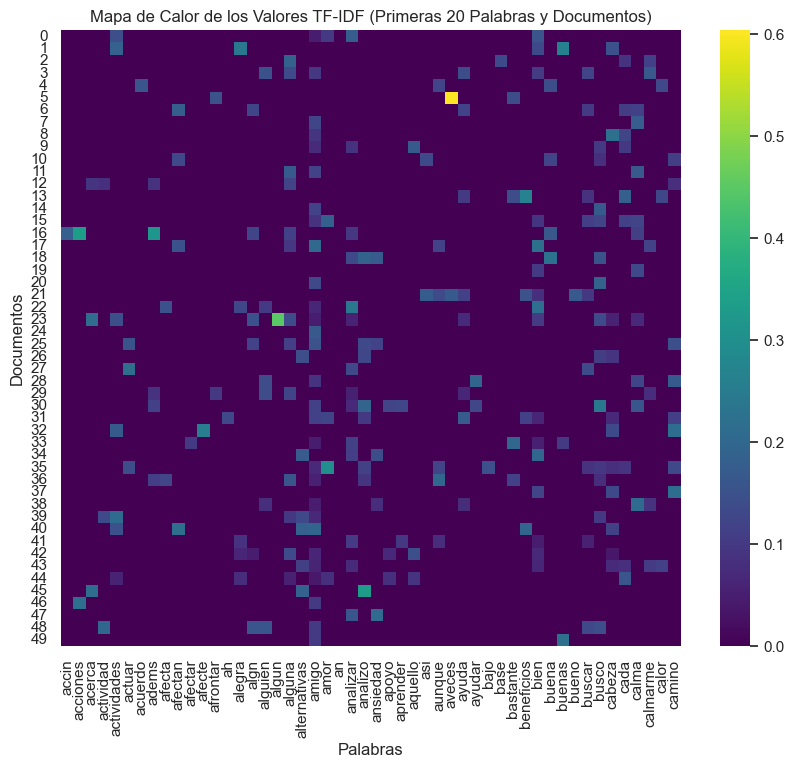

In [679]:
# Seleccionar una muestra de las primeras 20 palabras y documentos
muestra_tfidf = tfidf_df.iloc[:50, :50]

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(
    muestra_tfidf,
    cmap="viridis",
    annot=False,
    cbar=True,
    xticklabels=True,
    yticklabels=True
)
plt.title("Mapa de Calor de los Valores TF-IDF (Primeras 20 Palabras y Documentos)")
plt.xlabel("Palabras")
plt.ylabel("Documentos")
plt.show()

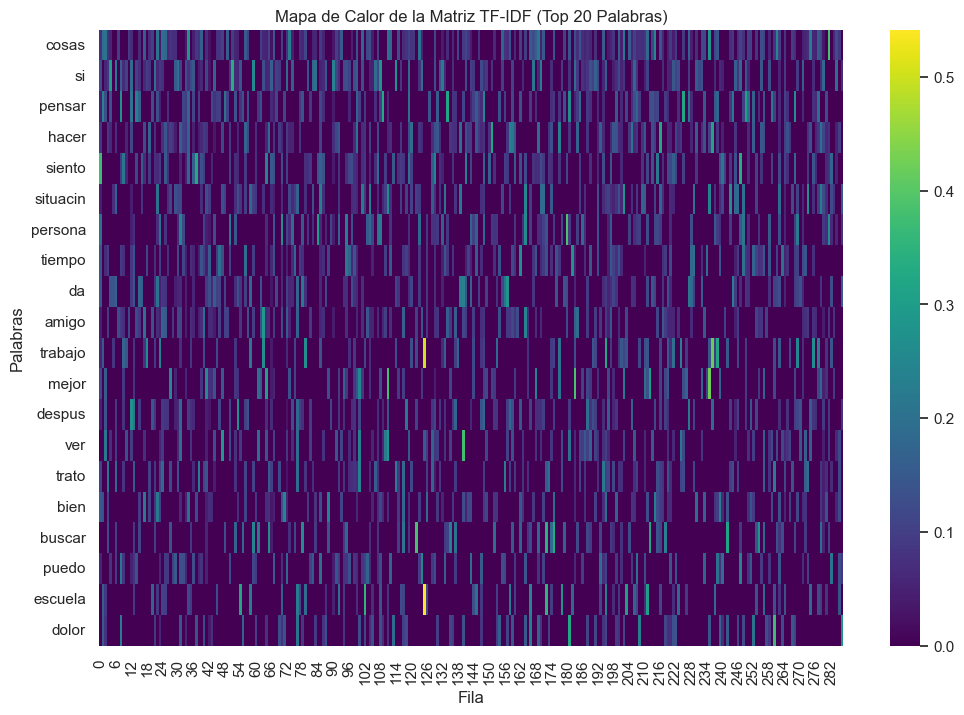

In [680]:
# Seleccionar las 20 palabras más frecuentes (mayores valores TF-IDF promedio)
top_words = tfidf_df.mean().sort_values(ascending=False).head(20).index

# Filtrar la matriz TF-IDF para estas palabras
tfidf_top = tfidf_df[top_words]

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_top.T, cmap="viridis", annot=False, cbar=True, yticklabels=top_words)
plt.title("Mapa de Calor de la Matriz TF-IDF (Top 20 Palabras)")
plt.xlabel("Fila")
plt.ylabel("Palabras")
plt.show()

<h1> Generacion de Embeddings usando Transformers </h1>

In [681]:
print("Columnas en el dataset:", dataset.columns)

# Combinar todas las columnas relacionadas con los sentimientos en una columna 'Texto_Procesado'
dataset['Texto_Procesado'] = dataset[
    [col for cols in sentimientos_preguntas.values() for col in cols]
].fillna("").apply(lambda x: " ".join(x), axis=1)

print("Primeras filas de Texto_Procesado:")
print(dataset['Texto_Procesado'].head())

Columnas en el dataset: Index(['Marca_temporal', 'ID_Unico', 'Edad', 'Genero', 'Nivel socioeconomico',
       'Grado de estudios', 'Actualmente_te_encuentras',
       'En_que_area_trabajas', 'Estado_origen', 'Municipio_origen',
       'Pregunta1', 'Pregunta2', 'Pregunta3', 'Pregunta4', 'Pregunta5',
       'Pregunta6', 'Pregunta7', 'Pregunta8', 'Pregunta9', 'Pregunta10',
       'Pregunta1_tokens', 'Pregunta2_tokens', 'Pregunta3_tokens',
       'Pregunta4_tokens', 'Pregunta5_tokens', 'Pregunta6_tokens',
       'Pregunta7_tokens', 'Pregunta8_tokens', 'Pregunta9_tokens',
       'Pregunta10_tokens'],
      dtype='object')
Primeras filas de Texto_Procesado:
0    dando clases puedo salir divertirme amigo si v...
1    sale bien escuela trabajo paz alegra salen cos...
2    ver recuerdos pensar escenarios imaginarios fe...
3    paso tiempo amigo salir comer lugares felicida...
4    hago recibo halagos hago ejercicio escucho pod...
Name: Texto_Procesado, dtype: object


'dccuchile/bert-base-spanish-wwm-cased' mas alto
dccuchile/bert-base-spanish-wwm-uncased' medio

In [713]:
# Cargar el modelo BERT en español y su tokenizador
modelo = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = AutoTokenizer.from_pretrained(modelo)
bert_es_model = AutoModel.from_pretrained(modelo)

# Función para generar embeddings en lotes
def generar_embeddings_bert_es(textos, modelo, tokenizer, batch_size=32):
    """
    Genera embeddings para un conjunto de textos utilizando BERT en español.
    """
    embeddings = []
    for i in range(0, len(textos), batch_size):
        lote = textos[i:i + batch_size]
        # Tokenización del lote
        inputs = tokenizer(lote, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = modelo(**inputs)
        # Extraer embeddings del token [CLS] (primer token)
        lote_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(lote_embeddings)
    return np.vstack(embeddings)

# Preparar los textos procesados
textos = [str(texto) for texto in dataset['Texto_Procesado'].tolist() if texto]

# Generar embeddings para todos los textos procesados
try:
    embeddings_array = generar_embeddings_bert_es(textos, bert_es_model, tokenizer)
    embeddings_array = np.array(embeddings_array)  # Convertir a array de NumPy
    print("Forma de la matriz de embeddings:", embeddings_array.shape)
except Exception as e:
    print("Error al generar embeddings:", str(e))

# Guardar los embeddings en el dataset (opcional)
dataset['Embeddings'] = list(embeddings_array)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Forma de la matriz de embeddings: (287, 768)


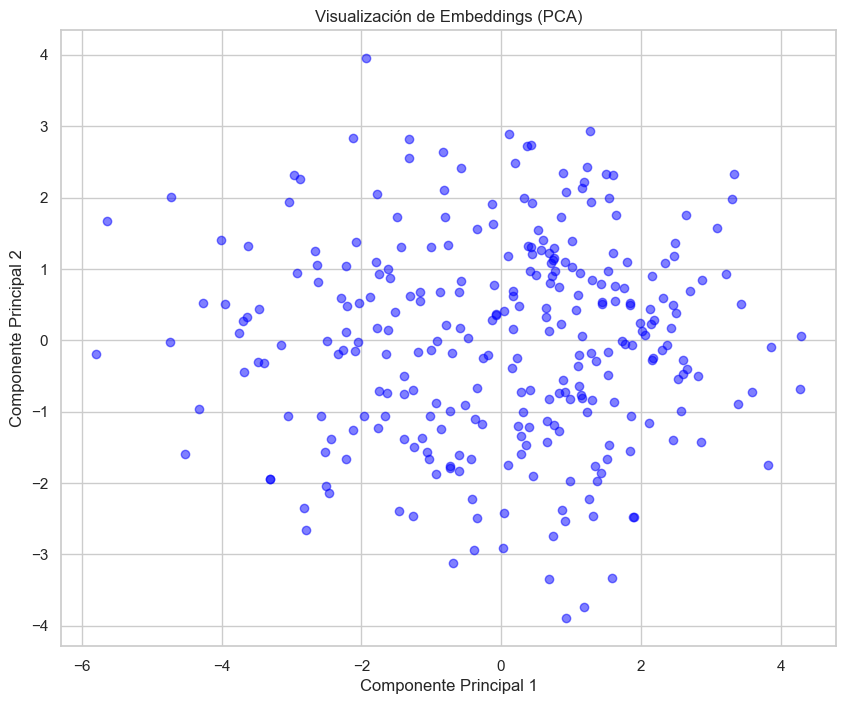

In [714]:
# Reducir la dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_array)

# Visualizar los embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='blue', alpha=0.5)
plt.title("Visualización de Embeddings (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

<h1> Division de DataSet </h1>

In [715]:
# Seleccionar características (X) y etiquetas (y)
X = embeddings_array  # Usaremos los embeddings generados como características
y = respuestas_df  # Las etiquetas de sentimiento

In [716]:
# Crear una etiqueta única basada en la columna dominante (puedes ajustar este criterio)
y_labels = respuestas_df.idxmax(axis=1)  # Seleccionar la columna con el valor dominante para cada fila

# Verificar las etiquetas asignadas
print("Etiquetas asignadas:")
print(y_labels.value_counts())

Etiquetas asignadas:
Tristeza                  61
Enojo                     51
Inquietud/Preocupación    46
Miedo                     46
Estrés                    45
Alegría                   38
Name: count, dtype: int64


In [717]:
# Seleccionar características (X) y etiquetas (y)
X = embeddings_array  # Los embeddings generados como características
y = y_labels    # Las etiquetas únicas por fila
print(f"Número de muestras en X: {len(X)}")
print(f"Número de muestras en y: {len(y)}")



Número de muestras en X: 287
Número de muestras en y: 287


In [718]:
# Asegúrate de que `X` y `y` sean arrays o pandas Series
X = np.array(embeddings_array)  # Los embeddings generados
y = pd.Series(y)  # Asegúrate de que y es una serie para usar value_counts()

# División estratificada para mantener la distribución de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verificar las dimensiones de los conjuntos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Número de muestras en y_train:", len(y_train))
print("Número de muestras en y_test:", len(y_test))

# Verificar la distribución de clases
print("\nDistribución de clases en y_train:")
print(y_train.value_counts())

print("\nDistribución de clases en y_test:")
print(y_test.value_counts())

Dimensiones de X_train: (229, 768)
Dimensiones de X_test: (58, 768)
Número de muestras en y_train: 229
Número de muestras en y_test: 58

Distribución de clases en y_train:
Tristeza                  48
Enojo                     41
Inquietud/Preocupación    37
Miedo                     37
Estrés                    36
Alegría                   30
Name: count, dtype: int64

Distribución de clases en y_test:
Tristeza                  13
Enojo                     10
Inquietud/Preocupación     9
Miedo                      9
Estrés                     9
Alegría                    8
Name: count, dtype: int64


K-Nearest Neighbors(KNN) 

In [719]:
# Crear y entrenar el clasificador KNN
k = 15 # Número de vecinos
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)

# Realizar predicciones
y_pred_knn = knn_classifier.predict(X_test)

# Evaluar el modelo
print("Resultados para K-Nearest Neighbors (KNN):")
print("\nMatriz de Confusión:")
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix_knn)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_knn))

print("\nPrecisión Global:")
print(f"{accuracy_score(y_test, y_pred_knn):.2f}")


Resultados para K-Nearest Neighbors (KNN):

Matriz de Confusión:
[[2 3 1 2 0 0]
 [0 3 2 2 2 1]
 [0 4 1 1 0 3]
 [1 0 2 2 2 2]
 [0 4 0 1 1 3]
 [0 5 2 3 1 2]]

Reporte de Clasificación:
                        precision    recall  f1-score   support

               Alegría       0.67      0.25      0.36         8
                 Enojo       0.16      0.30      0.21        10
                Estrés       0.12      0.11      0.12         9
Inquietud/Preocupación       0.18      0.22      0.20         9
                 Miedo       0.17      0.11      0.13         9
              Tristeza       0.18      0.15      0.17        13

              accuracy                           0.19        58
             macro avg       0.25      0.19      0.20        58
          weighted avg       0.23      0.19      0.19        58


Precisión Global:
0.19


Support Vector Machine

In [720]:
# Crear y entrenar el clasificador SVM
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)  # Cambiar kernel si es necesario
svm_classifier.fit(X_train, y_train)

# Realizar predicciones
y_pred_svm = svm_classifier.predict(X_test)

# Evaluar el modelo
print("Resultados para SVM:")
print("\nMatriz de Confusión:")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix_svm)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm))

print("\nPrecisión Global:")
print(f"{accuracy_score(y_test, y_pred_svm):.2f}")



Resultados para SVM:

Matriz de Confusión:
[[1 2 1 1 1 2]
 [1 3 1 1 2 2]
 [0 0 5 2 1 1]
 [4 0 1 1 2 1]
 [2 2 0 2 0 3]
 [2 2 2 2 3 2]]

Reporte de Clasificación:
                        precision    recall  f1-score   support

               Alegría       0.10      0.12      0.11         8
                 Enojo       0.33      0.30      0.32        10
                Estrés       0.50      0.56      0.53         9
Inquietud/Preocupación       0.11      0.11      0.11         9
                 Miedo       0.00      0.00      0.00         9
              Tristeza       0.18      0.15      0.17        13

              accuracy                           0.21        58
             macro avg       0.20      0.21      0.21        58
          weighted avg       0.21      0.21      0.21        58


Precisión Global:
0.21


Naive Bayes

In [721]:
# Convertir los embeddings a valores no negativos
X_train_non_negative = np.abs(X_train)
X_test_non_negative = np.abs(X_test)

# Entrenar Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_non_negative, y_train)

# Realizar predicciones
y_pred_nb = nb_classifier.predict(X_test_non_negative)

# Evaluar el modelo
print("\nResultados para Naive Bayes con Embeddings Absolutos:")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_nb))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_nb))
print("\nPrecisión Global:")
print(f"{accuracy_score(y_test, y_pred_nb):.2f}")


Resultados para Naive Bayes con Embeddings Absolutos:

Matriz de Confusión:
[[1 5 0 0 0 2]
 [0 4 2 0 2 2]
 [0 3 3 1 0 2]
 [1 1 2 2 1 2]
 [3 1 0 2 1 2]
 [0 4 3 2 1 3]]

Reporte de Clasificación:
                        precision    recall  f1-score   support

               Alegría       0.20      0.12      0.15         8
                 Enojo       0.22      0.40      0.29        10
                Estrés       0.30      0.33      0.32         9
Inquietud/Preocupación       0.29      0.22      0.25         9
                 Miedo       0.20      0.11      0.14         9
              Tristeza       0.23      0.23      0.23        13

              accuracy                           0.24        58
             macro avg       0.24      0.24      0.23        58
          weighted avg       0.24      0.24      0.23        58


Precisión Global:
0.24


*Árboles de Decisión*

In [722]:
# Crear y entrenar el Árbol de Decisión (criterio Gini = ID3)
dt_classifier = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_split=5, random_state=42)
dt_classifier.fit(X_train, y_train)

# Realizar predicciones
y_pred_dt = dt_classifier.predict(X_test)

# Evaluar el modelo
print("Resultados para Árbol de Decisión (Criterio Gini/ID3):")
print("\nMatriz de Confusión:")
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(conf_matrix_dt)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_dt))

print("\nPrecisión Global:")
print(f"{accuracy_score(y_test, y_pred_dt):.2f}")


Resultados para Árbol de Decisión (Criterio Gini/ID3):

Matriz de Confusión:
[[3 0 1 3 0 1]
 [4 3 0 0 0 3]
 [3 2 1 0 0 3]
 [2 0 0 3 1 3]
 [2 2 0 2 0 3]
 [6 2 0 2 1 2]]

Reporte de Clasificación:
                        precision    recall  f1-score   support

               Alegría       0.15      0.38      0.21         8
                 Enojo       0.33      0.30      0.32        10
                Estrés       0.50      0.11      0.18         9
Inquietud/Preocupación       0.30      0.33      0.32         9
                 Miedo       0.00      0.00      0.00         9
              Tristeza       0.13      0.15      0.14        13

              accuracy                           0.21        58
             macro avg       0.24      0.21      0.20        58
          weighted avg       0.23      0.21      0.19        58


Precisión Global:
0.21
